# Import libraries

In [42]:
import numpy as np
import pandas as pd
from cvxopt import solvers, matrix, spmatrix, spdiag, sparse
import matplotlib.pyplot as plt
import itertools
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Soft SVM

## Soft SVM implementation

In [31]:
def softsvm(l, trainX: np.array, trainy: np.array):
    """

    :param l: the parameter lambda of the soft SVM algorithm
    :param trainX: numpy array of size (m, d) containing the training sample
    :param trainy: numpy array of size (m, 1) containing the labels of the training sample
    :return: linear predictor w, a numpy array of size (d, 1)
    """
    # We assume z=[e_1,...,e_m,w_1,...,w_d].T
    m, d = trainX.shape

    # H=2l * [0_mxm, 0_mxd]
    #        [0_dxm, I_dxd]
    H = 2 * l * spdiag([spmatrix(np.zeros(m), range(m), range(m)), spmatrix(np.ones(d), range(d), range(d))])

    # u=1/m * [1_mx1]
    #         [0_dx1]
    u = 1/m * matrix(np.concatenate((np.ones((m, 1)), np.zeros((d, 1))), axis=None))

    yX = np.diag(trainy) @ trainX
    # A=[I_mxm, yX_mxd]
    #   [I_mxm, 0_mxd ]

    # Option 1: Memory Efficiency
    #A = sparse([[matrix(np.identity(m)), matrix(np.identity(m))],
    #            [matrix(yX),             matrix(np.zeros((m, d)))]])

    # Option 2: Run Time Efficiency
    a = np.block([[np.identity(m), yX],
                  [np.identity(m), np.zeros((m, d))]])
    A = matrix(a)

    # v=[1_mx1]
    #   [0_mx1]
    v = matrix(np.concatenate((np.ones((m, 1)), np.zeros((m, 1))), axis=0))

    solvers.options['show_progress'] = False
    sol = solvers.qp(H, u, -A, -v)
    z = sol["x"]

    return np.array(z[-d:])

## Sanity test for Soft SVM

In [32]:
# Load MNIST data
data = np.load('mnist_data.npz')
trainX = data['Xtrain']
testX = data['Xtest']
trainy = data['Ytrain']
testy = data['Ytest']

m = 100
d = trainX.shape[1]

# Get a random m training examples from the training set
indices = np.random.permutation(trainX.shape[0])
_trainX = trainX[indices[:m]]
_trainy = trainy[indices[:m]]

# run the softsvm algorithm
w = softsvm(10, _trainX, _trainy)

# tests to make sure the output is of the intended class and shape
assert isinstance(w, np.ndarray), "The output of the function softsvm should be a numpy array"
assert w.shape[0] == d and w.shape[1] == 1, f"The shape of the output should be ({d}, 1)"

# get a random example from the test set, and classify it
i = np.random.randint(0, testX.shape[0])
predicty = np.sign(testX[i] @ w)

# this line should print the classification of the i'th test sample (1 or -1).
print(f"The {i}'th test sample was classified as {predicty}")

The 724'th test sample was classified as [1.]


## Test the Soft SVM error as a function of lambda size

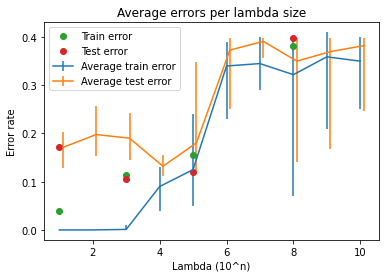

In [33]:
# Experiment 1 - Checking the test error as a function of lambda size

# Load MNIST data
data = np.load('mnist_data.npz')
trainX = data['Xtrain']
testX = data['Xtest']
trainy = data['Ytrain']
testy = data['Ytest']

m = 100
d = trainX.shape[1]

train_errors_sum = 0
train_min_error = 1
train_max_error = 0
train_errors = []
train_min_errors_list = []
train_max_errors_list = []
lambda_size_for_train = []

test_errors_sum = 0
test_min_error = 1
test_max_error = 0
test_errors = []
test_min_errors_list = []
test_max_errors_list = []
lambda_size_for_test = []

n_list = list(range(1, 11))

for n in n_list:
    for iteration in range(10):
        current_lambda = 10 ** n
        # Get a random m training examples from the training set
        indices = np.random.permutation(trainX.shape[0])
        _trainX = trainX[indices[:m]]
        _trainy = trainy[indices[:m]]

        # run the softsvm algorithm
        w = softsvm(current_lambda, _trainX, _trainy)

        # tests to make sure the output is of the intended class and shape
        assert isinstance(w, np.ndarray), "The output of the function softsvm should be a numpy array"
        assert w.shape[0] == d and w.shape[1] == 1, f"The shape of the output should be ({d}, 1)"

        # get a random example from the test set, and classify it
        predicty_train = np.sign(_trainX @ w)
        train_mean_error = np.mean(_trainy.reshape(-1, 1) != predicty_train)
        train_errors_sum += train_mean_error
        train_min_error = min(train_min_error, train_mean_error)
        train_max_error = max(train_max_error, train_mean_error)

        predicty_test = np.sign(testX @ w)
        test_mean_error = np.mean(testy.reshape(-1, 1) != predicty_test)
        test_errors_sum += test_mean_error
        test_min_error = min(test_min_error, test_mean_error)
        test_max_error = max(test_max_error, test_mean_error)

    lambda_size_for_train.append(n)
    lambda_size_for_test.append(n+0.1)

    train_errors.append(train_errors_sum / 10)
    train_min_errors_list.append(train_min_error)
    train_max_errors_list.append(train_max_error)
    train_errors_sum = 0
    train_min_error = 1
    train_max_error = 0

    test_errors.append(test_errors_sum / 10)
    test_min_errors_list.append(test_min_error)
    test_max_errors_list.append(test_max_error)
    test_errors_sum = 0
    test_min_error = 1
    test_max_error = 0

plt.title("Average errors per lambda size")
train_min_max = [np.subtract(train_errors, train_min_errors_list), np.subtract(train_max_errors_list, train_errors)]
test_min_max = [np.subtract(test_errors, test_min_errors_list), np.subtract(test_max_errors_list, test_errors)]

plt.errorbar(lambda_size_for_train, train_errors, yerr=train_min_max, label='Average train error')
plt.errorbar(lambda_size_for_test, test_errors, yerr=test_min_max, label='Average test error')
plt.xlabel('Lambda (10^n)')
plt.ylabel('Error rate')


# Experiment 2 - Checking the Minimum and Maximus errors as a function of lambda size

# Load MNIST data
data = np.load('mnist_data.npz')
trainX = data['Xtrain']
testX = data['Xtest']
trainy = data['Ytrain']
testy = data['Ytest']

m = 1000
d = trainX.shape[1]

train_errors = []
lambda_size_for_train = []

test_errors = []
lambda_size_for_test = []

n_list = [1, 3, 5, 8]

for n in n_list:
    current_lambda = 10 ** n
    # Get a random m training examples from the training set
    indices = np.random.permutation(trainX.shape[0])
    _trainX = trainX[indices[:m]]
    _trainy = trainy[indices[:m]]

    # run the softsvm algorithm
    w = softsvm(current_lambda, _trainX, _trainy)

    # tests to make sure the output is of the intended class and shape
    assert isinstance(w, np.ndarray), "The output of the function softsvm should be a numpy array"
    assert w.shape[0] == d and w.shape[1] == 1, f"The shape of the output should be ({d}, 1)"

    predicty_train = np.sign(_trainX @ w)
    train_errors_sum = np.mean(_trainy.reshape(-1, 1) != predicty_train)

    predicty_test = np.sign(testX @ w)
    test_errors_sum = np.mean(testy.reshape(-1, 1) != predicty_test)

    lambda_size_for_train.append(n)
    lambda_size_for_test.append(n)

    train_errors.append(train_errors_sum)
    test_errors.append(test_errors_sum)

plt.plot(lambda_size_for_train, train_errors, 'o', label='Train error')
plt.plot(lambda_size_for_test, test_errors, 'o', label='Test error')
plt.legend()
plt.show()

# Soft SVM RBF

# Soft SVM RBF implementation

In [34]:
def softsvmrbf(l: float, sigma: float, trainX: np.array, trainy: np.array):
    """

    :param l: the parameter lambda of the soft SVM algorithm
    :param sigma: the bandwidth parameter sigma of the RBF kernel.
    :param trainX: numpy array of size (m, d) containing the training sample
    :param trainy: numpy array of size (m, 1) containing the labels of the training sample
    :return: numpy array of size (m, 1) which describes the coefficients found by the algorithm
    """
    # We assume z=[e_1,...,e_m,a_1,...,a_m].T
    m, d = trainX.shape

    G = gram_matrix_calculation(trainX, sigma)

    # H=2l * [0_mxm, 0_mxm]
    #        [0_mxm, G_mxm]
    H = 2 * l * spdiag([spmatrix(np.ones(m) * 0.01, range(m), range(m)), matrix(G + np.identity(m) * 0.01)])

    # u=1/m * [1_mx1]
    #         [0_mx1]
    u = 1/m * matrix(np.concatenate((np.ones((m, 1)), np.zeros((m, 1))), axis=None))

    yG = np.diag(trainy) @ G
    # A=[I_mxm, yG_mxm]
    #   [I_mxm, 0_mxm ]

    # Option 1: Memory Efficiency
    # A = sparse([[matrix(np.identity(m)), matrix(np.identity(m))],
    #             [matrix(yG),             matrix(np.zeros((m, m)))]])

    # Option 2: Run Time Efficiency
    a = np.block([[np.identity(m), yG],
                  [np.identity(m), np.zeros((m, m))]])
    A = matrix(a)

    # v=[1_mx1]
    #   [0_mx1]
    v = matrix(np.concatenate((np.ones((m, 1)), np.zeros((m, 1))), axis=0))

    solvers.options['show_progress'] = False
    sol = solvers.qp(H, u, -A, -v)
    z = sol["x"]

    return np.array(z[-m:])


def gram_matrix_calculation(X, sigma):
    m = X.shape[0]
    G = np.zeros((m, m))

    for i in range(m):
        for j in range(m):
            G[i][j] = RBF_kernel(X[i], X[j], sigma)

    return G


def RBF_kernel(x1, x2, sigma):
    return np.exp(-(np.linalg.norm(x1 - x2, 2) / (2 * sigma)))

## Sanity test

In [35]:
# Load points data
data = np.load('points_data.npz')
trainX = data['Xtrain']
testX = data['Xtest']
trainy = data['Ytrain']
testy = data['Ytest']

m = 100

# Get a random m training examples from the training set
indices = np.random.permutation(trainX.shape[0])
_trainX = trainX[indices[:m]]
_trainy = trainy[indices[:m]]

_trainy = _trainy.flatten()

# run the softsvm algorithm
w = softsvmbf(10, 0.1, _trainX, _trainy)

# tests to make sure the output is of the intended class and shape
assert isinstance(w, np.ndarray), "The output of the function softsvmbf should be a numpy array"
assert w.shape[0] == m and w.shape[1] == 1, f"The shape of the output should be ({m}, 1)"

## Scatter plot of the data points

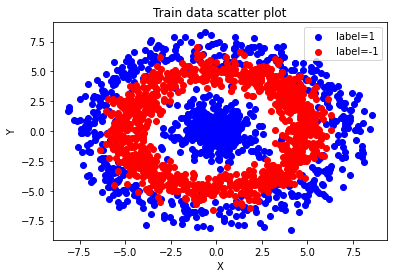

In [36]:
# Load points data
data = np.load('points_data.npz')
trainX = data['Xtrain']
trainy = data['Ytrain']

X_x_value = trainX[:, 0]
X_y_value = trainX[:, 1]
df = pd.DataFrame({'X': X_x_value, 'Y': X_y_value, 'Label': trainy[:, 0]})

df1 = df[df['Label'] == 1]
df1 = df1.drop(columns=['Label'])
type_1_data = df1.to_numpy()
type_1_x = type_1_data[:, 0]
type_1_y = type_1_data[:, 1]

df2 = df[df['Label'] == -1]
df2 = df2.drop(columns=['Label'])
type_2_data = df2.to_numpy()
type_2_x = type_2_data[:, 0]
type_2_y = type_2_data[:, 1]

plt.title("Train data scatter plot")

plt.scatter(type_1_x, type_1_y, label='label=1', color='b')
plt.scatter(type_2_x, type_2_y, label='label=-1', color='r')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

## Experiment 1 - Using K-Fold-Cross-Validation to test Soft SVM RBF

### Soft SVM RBF K-Fold-Cross-Validation implementation

In [37]:
def softsvmrbf_k_fold_cross_validation(trainX, trainy, hyper_parameters_list, k):
    m, d = trainX.shape

    validation_size = int(m / k)
    train_size = m - validation_size

    validations_averages = []

    # Get a random permutation of the training examples from the training set
    indices = np.random.permutation(trainX.shape[0])

    # hyper_parameters[0] = lambda, hyper_parameters[1] = sigma
    for hyper_parameters in hyper_parameters_list:
        validation_errors_averages_sum = 0

        # Split the training sample into k equal parts
        for i in range(k):
            validation_X = trainX[indices[i*validation_size:(i+1)*validation_size]]
            validation_y = trainy[indices[i*validation_size:(i+1)*validation_size]]
            training_set_X = np.delete(trainX, indices[i*validation_size:(i+1)*validation_size], 0)
            training_set_y = np.delete(trainy, indices[i*validation_size:(i+1)*validation_size], 0)

            validation_y = validation_y.T[0]
            training_set_y = training_set_y.T[0]

            # run the softsvm algorithm
            w = softsvmrbf(hyper_parameters[0], hyper_parameters[1], training_set_X, training_set_y)

            # tests to make sure the output is of the intended class and shape
            assert isinstance(w, np.ndarray), "The output of the function softsvm should be a numpy array"
            assert w.shape[0] == train_size and w.shape[1] == 1, f"The shape of the output should be ({train_size}, 1)"

            validation_errors_sum = 0

            for j1 in range(validation_size):
                kernels_sum = 0

                for j2 in range(train_size):
                    kernels_sum += w[j2] * RBF_kernel(training_set_X[j2], validation_X[j1], hyper_parameters[1])

                if np.sign(kernels_sum) >= 0:
                    predicty_test = 1
                else:
                    predicty_test = -1

                if predicty_test != validation_y[j1]:
                    validation_errors_sum += 1

            validation_errors_averages_sum += (validation_errors_sum / validation_size)

        validation_average = validation_errors_averages_sum / k
        print("For the pair: ({}, {}), the average validation error is: {}"
              .format(hyper_parameters[0], hyper_parameters[1], validation_average))

        validations_averages.append(validation_average)

    min_validation_error = min(validations_averages)
    min_validation_error_index = validations_averages.index(min_validation_error)

    min_lambda, min_sigma = hyper_parameters_list[min_validation_error_index]
    print("The pair: ({}, {}), was selected by the cross validation"
          .format(min_lambda, min_sigma))

    # run the softsvm algorithm
    w = softsvmrbf(min_lambda, min_sigma, trainX, trainy.T[0])

    # tests to make sure the output is of the intended class and shape
    assert isinstance(w, np.ndarray), "The output of the function softsvm should be a numpy array"
    assert w.shape[0] == m and w.shape[1] == 1, f"The shape of the output should be ({m}, 1)"

    return w, min_sigma

### Testing the Soft SVM RBF K-Fold-Cross-Validation

In [38]:
# Load points data
data = np.load('points_data.npz')
trainX = data['Xtrain']
testX = data['Xtest']
trainy = data['Ytrain']
testy = data['Ytest']

# Real Test
lambda_and_sigma_list = [[1, 10, 100], [0.001, 0.5, 1]]

# Sanity Test
# lambda_and_sigma_list = [[1], [0.001]]

combined_product = itertools.product(*lambda_and_sigma_list)
hyper_parameters_list = list(combined_product)

w, min_sigma = softsvmrbf_k_fold_cross_validation(trainX, trainy, hyper_parameters_list, 5)

errors_sum = 0

for j1 in range(testX.shape[0]):
    kernels_sum = 0

    for j2 in range(trainX.shape[0]):
        kernels_sum += w[j2] * RBF_kernel(trainX[j2], testX[j1], min_sigma)

    if np.sign(kernels_sum) >= 0:
        predicty_test = 1
    else:
        predicty_test = -1

    if predicty_test != testy[j1]:
        errors_sum += 1

errors_sum_average = (errors_sum / testX.shape[0])
print("The test error of the resulting classifier is: {}".format(errors_sum_average))

For the pair: (1, 0.001), the average validation error is: 0.08349999999999999
For the pair: (1, 0.5), the average validation error is: 0.0885
For the pair: (1, 1), the average validation error is: 0.139
For the pair: (10, 0.001), the average validation error is: 0.08349999999999999
For the pair: (10, 0.5), the average validation error is: 0.0885
For the pair: (10, 1), the average validation error is: 0.139
For the pair: (100, 0.001), the average validation error is: 0.08349999999999999
For the pair: (100, 0.5), the average validation error is: 0.0885
For the pair: (100, 1), the average validation error is: 0.139
The pair: (1, 0.001), was selected by the cross validation
The test error of the resulting classifier is: 0.07


## Experiment 2 - Using K-Fold-Cross-Validation to test Soft SVM

### Soft SVM K-Fold-Cross-Validation implementation

In [39]:
def softsvm_k_fold_cross_validation(trainX, trainy, hyper_parameters_list, k):
    m, d = trainX.shape

    validation_size = int(m / k)

    validations_averages = []

    # Get a random permutation of the training examples from the training set
    indices = np.random.permutation(trainX.shape[0])

    # hyper_parameters[0] = lambda, hyper_parameters[1] = sigma
    for hyper_parameters in hyper_parameters_list:
        validation_errors_averages_sum = 0

        # Split the training sample into k equal parts
        for i in range(k):
            validation_X = trainX[indices[i*validation_size:(i+1)*validation_size]]
            validation_y = trainy[indices[i*validation_size:(i+1)*validation_size]]
            training_set_X = np.delete(trainX, indices[i*validation_size:(i+1)*validation_size], 0)
            training_set_y = np.delete(trainy, indices[i*validation_size:(i+1)*validation_size], 0)

            validation_y = validation_y.T[0]
            training_set_y = training_set_y.T[0]

            # run the softsvm algorithm
            w = softsvm(hyper_parameters, training_set_X, training_set_y)

            # tests to make sure the output is of the intended class and shape
            assert isinstance(w, np.ndarray), "The output of the function softsvm should be a numpy array"
            assert w.shape[0] == d and w.shape[1] == 1, f"The shape of the output should be ({d}, 1)"

            predicty_test = np.sign(validation_X @ w)
            validation_errors_averages_sum += np.mean(np.array([validation_y]).T != predicty_test)

        validation_average = validation_errors_averages_sum / k
        print("For the lambda: {}, the average validation error is: {}"
              .format(hyper_parameters, validation_average))

        validations_averages.append(validation_average)

    min_validation_error = min(validations_averages)
    min_validation_error_index = validations_averages.index(min_validation_error)

    min_lambda = hyper_parameters_list[min_validation_error_index]
    print("The lambda: {}, was selected by the cross validation"
          .format(min_lambda))

    # run the softsvm algorithm
    w = softsvm(min_lambda, trainX, trainy.T[0])

    # tests to make sure the output is of the intended class and shape
    assert isinstance(w, np.ndarray), "The output of the function softsvm should be a numpy array"
    assert w.shape[0] == d and w.shape[1] == 1, f"The shape of the output should be ({d}, 1)"

    return w

### Testing the Soft SVM K-Fold-Cross-Validation

In [45]:
# Load points data
data = np.load('points_data.npz')
trainX = data['Xtrain']
testX = data['Xtest']
trainy = data['Ytrain']
testy = data['Ytest']

# Real Test
lambda_list = [1, 10, 100]

# Sanity Test
# lambda_list = [1]

w = softsvm_k_fold_cross_validation(trainX, trainy, lambda_list, 5)

predicty_test = np.sign(testX @ w)
test_mean_error = np.mean(testy != predicty_test)

print("The test error of the resulting classifier is: {}".format(test_mean_error))

For the lambda: 1, the average validation error is: 0.49799999999999994
For the lambda: 10, the average validation error is: 0.49799999999999994
For the lambda: 100, the average validation error is: 0.49799999999999994
The lambda: 1, was selected by the cross validation
The test error of the resulting classifier is: 0.51


## Grid view of Soft SVM RBF as a function of lambda

In [46]:
def data_imshow_plot(w, trainX, sigma):
    grid_size = 100
    x1_max = 8
    x1_min = -8
    axis = np.linspace(x1_min, x1_max, num=grid_size)
    x, y = np.meshgrid(axis, axis)
    testX = np.stack((x, y), axis=2).reshape(-1, 2)
    predicty_test = np.array([])

    for j1 in range(testX.shape[0]):
        kernels_sum = 0

        for j2 in range(trainX.shape[0]):
            kernels_sum += w[j2] * RBF_kernel(trainX[j2], testX[j1], sigma)

        if np.sign(kernels_sum) >= 0:
            predicty_test = np.concatenate((predicty_test, 1), axis=None)
        else:
            predicty_test = np.concatenate((predicty_test, -1), axis=None)

    predicty_test = predicty_test.reshape(grid_size, grid_size)
    extent = -8, 8, -8, 8
    cmap = ListedColormap(['r', 'b'])
    red_patch = mpatches.Patch(color='red', label='y=-1')
    blue_patch = mpatches.Patch(color='blue', label='y=1')
    plt.imshow(predicty_test, cmap=cmap, extent=extent)
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

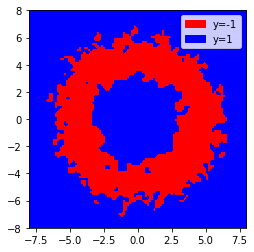

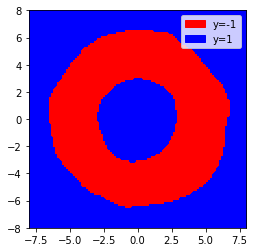

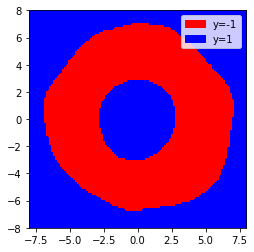

In [47]:
# Load points data
data = np.load('points_data.npz')
trainX = data['Xtrain']
trainy = data['Ytrain']

# Real Test
lambda_and_sigma_list = [[100], [0.001, 0.5, 1]]

# Sanity Test
# lambda_and_sigma_list = [[100], [0.001]]

combined_product = itertools.product(*lambda_and_sigma_list)
hyper_parameters_list = list(combined_product)

for hyper_parameters in hyper_parameters_list:
    # run the softsvm algorithm
    w = softsvmrbf(hyper_parameters[0], hyper_parameters[1], trainX, trainy.T[0])

    data_imshow_plot(w, trainX, hyper_parameters[1])